In [12]:
# conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

## Importing Libraries

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import seaborn as sns

In [14]:
# torch.cuda.is_available()

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
dataset = CIFAR10(root='./data', download=True, transform=ToTensor())
print(f"No.of images in dataset: {len(dataset)}")
train_ds, val_ds = random_split(dataset, [40000, 10000])
batch_size = 128
device = get_default_device()

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Files already downloaded and verified
No.of images in dataset: 50000


In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Cifar10_Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Flatten(), 
            nn.Linear(64*16*16, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, momentum = 0.0):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [19]:
num_classes = 10
model = Cifar10_Model()
to_device(model, device)

Cifar10_Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16384, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [20]:
evaluate(model, val_loader)

{'val_acc': 0.12099609524011612, 'val_loss': 2.298126697540283}

In [21]:
#Hyper parameters for training model
num_epochs = 20
opt_func=torch.optim.SGD
momentum = 0.9 
#opt_func = torch.optim.Adam
lr = 0.001

In [22]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func, momentum)

Epoch [0], val_loss: 1.4315, val_acc: 0.4837
Epoch [1], val_loss: 1.2012, val_acc: 0.5652
Epoch [2], val_loss: 1.0472, val_acc: 0.6269
Epoch [3], val_loss: 0.9535, val_acc: 0.6670
Epoch [4], val_loss: 0.9248, val_acc: 0.6729
Epoch [5], val_loss: 0.8981, val_acc: 0.6866
Epoch [6], val_loss: 0.8662, val_acc: 0.6962
Epoch [7], val_loss: 0.8738, val_acc: 0.6955
Epoch [8], val_loss: 0.8710, val_acc: 0.7021
Epoch [9], val_loss: 0.8935, val_acc: 0.6994
Epoch [10], val_loss: 0.9078, val_acc: 0.7064
Epoch [11], val_loss: 0.9335, val_acc: 0.7110
Epoch [12], val_loss: 0.9727, val_acc: 0.7060
Epoch [13], val_loss: 1.0020, val_acc: 0.7117
Epoch [14], val_loss: 1.0328, val_acc: 0.7101
Epoch [15], val_loss: 1.0684, val_acc: 0.7112
Epoch [16], val_loss: 1.0886, val_acc: 0.7123
Epoch [17], val_loss: 1.1182, val_acc: 0.7118
Epoch [18], val_loss: 1.1274, val_acc: 0.7124
Epoch [19], val_loss: 1.1520, val_acc: 0.7125


In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

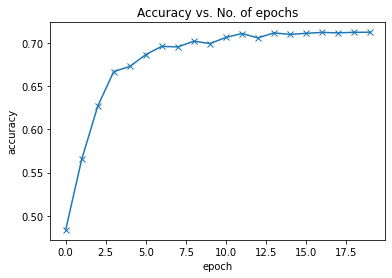

In [24]:
plot_accuracies(history)

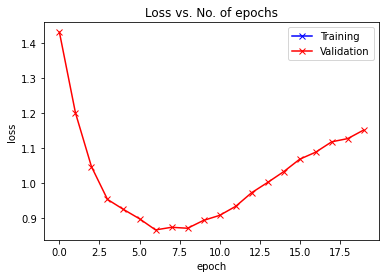

In [25]:
plot_losses(history)

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [27]:
test_ds = CIFAR10(root='./data', train=False, transform=ToTensor())

test_loader = DataLoader(test_ds, batch_size)
test_loader = DeviceDataLoader(test_loader, device)

# result = evaluate(final_model, test_loader)
# print(f'Test Accuracy:{result["val_acc"]*100:.2f}%')

Label: cat , Predicted: cat


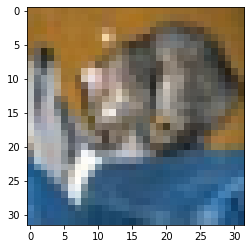

In [28]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [31]:
result = evaluate(model, test_loader)
result
# print(f'Test Accuracy:{result["val_acc"]*100:.2f}%')

{'val_acc': 0.7020371556282043, 'val_loss': 1.203417420387268}